# 2. 2D example (advanced inference, diagnostics)

In [9]:
import numpy as np
import torch

In [10]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)  # reproducible sampling


<br/>

**2D function example**: Currin et al. (1988)

$f(x) = \left[1 - \exp{\left(1 - \dfrac{1}{2 x_2}\right)}\right]\,\left(\dfrac{2300 x_{1}^3 + 1900 x_{1}^2 + 2092 x_{1} + 60}{100 x_{1}^3 + 500 x_{1}^2 + 4 x_{1} + 20}\right)$

<br/>


In [11]:
# function to learn (normally a high-dimensional, expensive deterministic model)
from GPErks.utils.test_functions import currin_exp
D = 2

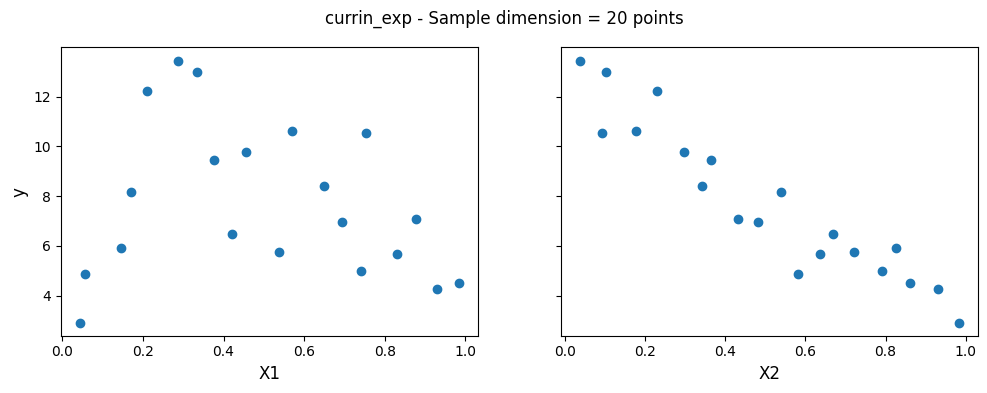

In [12]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset.build_from_function(
    currin_exp,
    D,
    n_train_samples=20,
    n_test_samples=25,
    design="lhs",
    seed=seed,
)
dataset.plot()

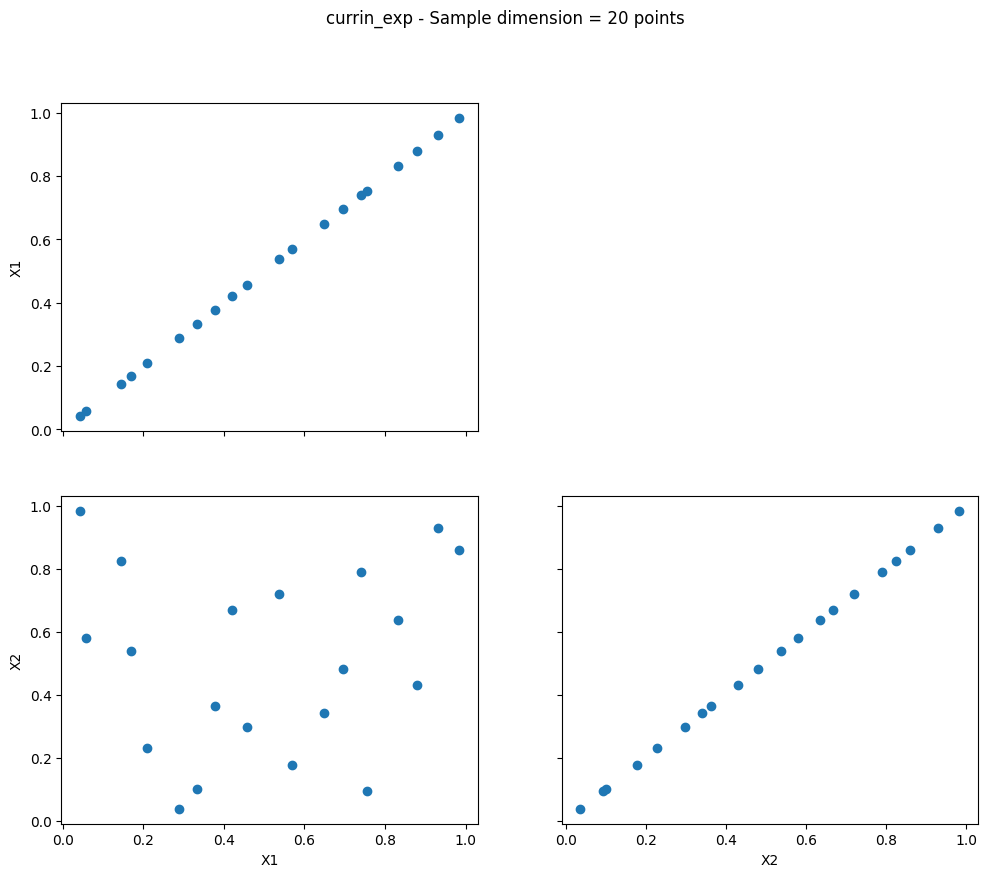

In [13]:
dataset.plot_pairwise()

In [14]:
# choose likelihood
from gpytorch.likelihoods import GaussianLikelihood
likelihood = GaussianLikelihood()

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# choose mean function
from gpytorch.means import LinearMean
mean_function = LinearMean(input_size=dataset.input_size)

In [16]:
# choose kernel
from gpytorch.kernels import RBFKernel, ScaleKernel
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))

In [17]:
# choose metrics
from torchmetrics import MeanSquaredError, R2Score
metrics = [MeanSquaredError(), R2Score()]

In [18]:
# define experiment
from GPErks.gp.experiment import GPExperiment
experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed  # reproducible training
)

In [19]:
# choose training options: device + optimizer
device = "cpu"
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

In [20]:
# train model
from GPErks.train.emulator import GPEmulator
emulator = GPEmulator(experiment, device)
emulator.train(optimizer)

INFO:2025-05-16 16:26:14,489:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:26:14,489:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:26:14,511:emulator:_train_once:L303: [  1/100] Training Loss: 0.8316 - MeanSquaredError: 0.0849 - R2Score: 0.9151
INFO:2025-05-16 16:26:14,515:emulator:_train_once:L303: [  2/100] Training Loss: 0.7894 - MeanSquaredError: 0.0816 - R2Score: 0.9184
INFO:2025-05-16 16:26:14,518:emulator:_train_once:L303: [  3/100] Training Loss: 0.7519 - MeanSquaredError: 0.0795 - R2Score: 0.9205
INFO:2025-05-16 16:26:14,522:emulator:_train_once:L303: [  4/100] Training Loss: 0.7177 - MeanSquaredError: 0.0780 - R2Score: 0.9220
INFO:2025-05-16 16:26:14,525:emulator:_train_once:L303: [  5/100] Training Loss: 0.6858 - MeanSquaredError: 0.

(OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.6342])),
              ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
               tensor(1.0000e-04)),
              ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
               tensor(inf)),
              ('mean_module.weights',
               tensor([[-0.0557],
                       [-2.5851]])),
              ('mean_module.bias', tensor([1.2667])),
              ('covar_module.raw_outputscale', tensor(-2.0184)),
              ('covar_module.base_kernel.raw_lengthscale',
               tensor([[-2.0959,  2.1659]])),
              ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
               tensor(inf)),
              ('covar_module.raw_outputscale_constraint.lower_bound',
               tensor(0.)),
              ('covar_module.raw_outputscale_constraint.upper_bo

                   Score
MeanSquaredError  0.7254
R2Score           0.9013


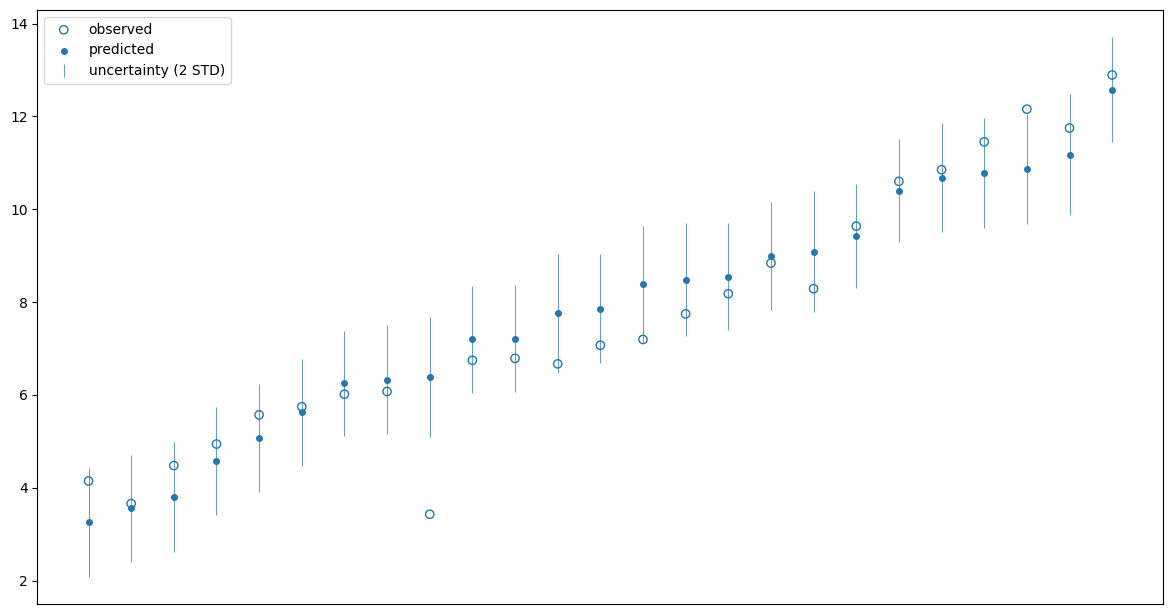

In [21]:
# inference on stored test set
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()
inference.plot()

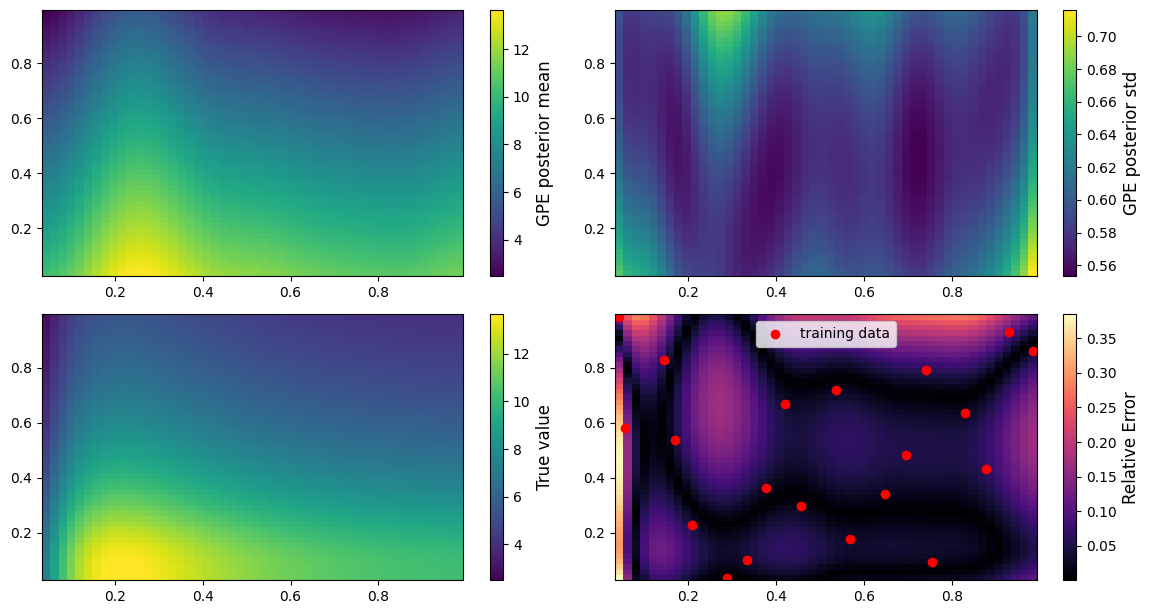

In [29]:
# bonus: inference on 2-dimensional grid
inference.interpolate_2Dgrid(currin_exp)  # can add function f as optional argument

In [30]:
# perk n.2: diagnostics
from GPErks.perks.diagnostics import Diagnostics
diagnostics = Diagnostics(emulator)

y_mean, y_std, y_covar = emulator.predict(dataset.X_test, with_covar=True)
print( y_covar.shape )

(25, 25)



<br/>

Bastos, L.S. and O’Hagan, A (2009) **Diagnostics for Gaussian Process Emulators.** Technometrics, 51:4, 425-438. doi:10.1198/TECH.2009.08019

<br/>


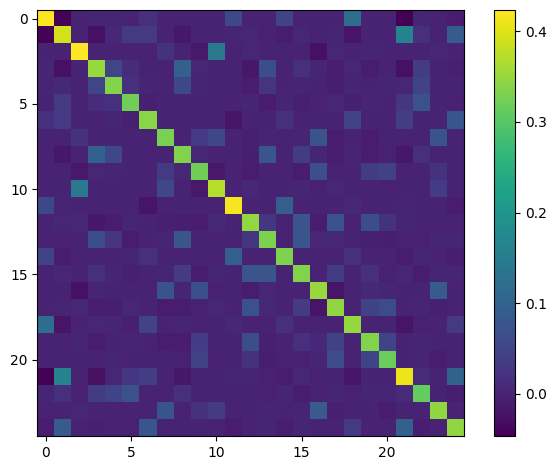

In [31]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 1)
h = axis.imshow(y_covar)
cbar = fig.colorbar(h, ax=axis)
fig.tight_layout()
plt.show()

In [32]:
diagnostics.summary()

                      Observed  Expected      Std
Chi-Squared            46.6326    25.000   7.0711
Mahalanobis Distance   44.0926    25.000  12.1008
Credible Interval       0.9200     0.791   0.0737


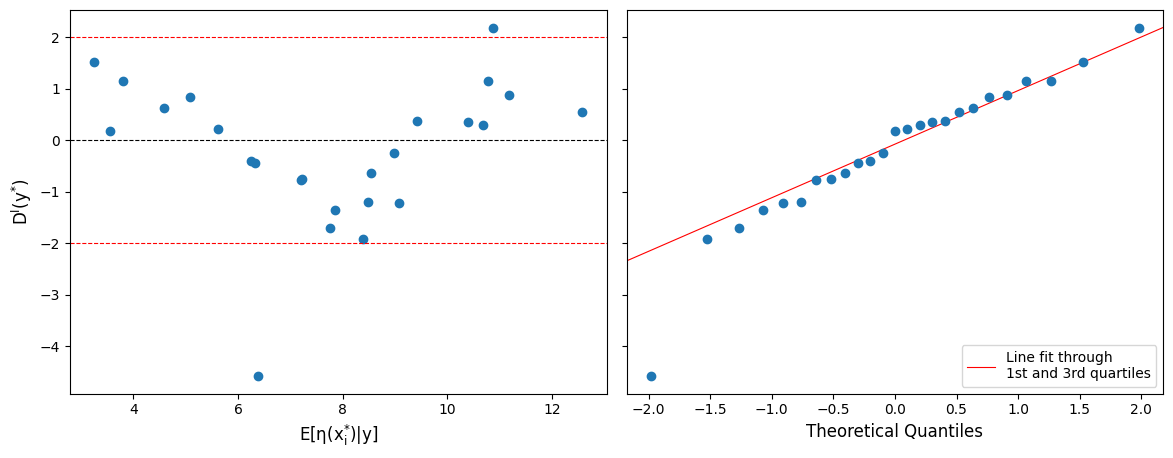

In [33]:
diagnostics.plot(errors_type="correlated")

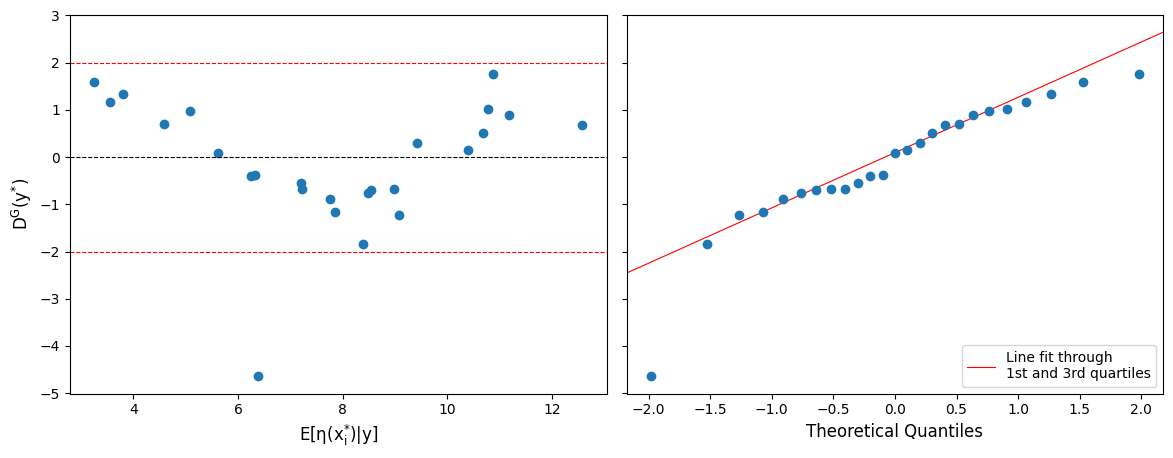

In [34]:
diagnostics.plot(errors_type="uncorrelated")

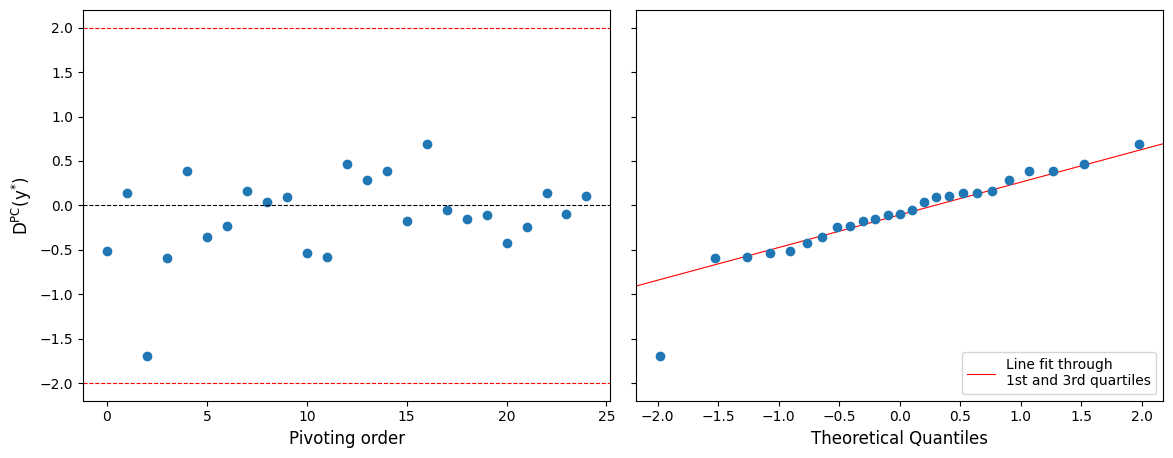

In [35]:
diagnostics.plot(errors_type="pivoted")